## Speech to Text with OpenVINO

In [ ]:
#install all dependencies
%pip install -q "librosa>=0.8.1" "openvino-dev>=2023.1.0" "numpy<1.24" matplotlib torch torchaudio transformers scipy 

**IMPORTS**

In [2]:
#import all dependecies
from pathlib import Path
import sys

import torch
import torch.nn as nn
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa 
import librosa.display
import numpy as np
import scipy
import openvino as ov
from pathlib import Path
from transformers import pipeline, AutoTokenizer
from transformers.integrations import deepspeed
from optimum.intel.openvino import OVModelForSeq2SeqLM, OVModelForSequenceClassification
from notebook_utils import download_file



**Settings**

In [3]:
#setting up folders and models
model_folder = "model"
download_folder = "output"
data_folder = "data"

precision = "FP16"
model_name = "quartznet-15x5-en"

**Download and Convert Public Model**

In [4]:
# Check if a model is already downloaded (to the download directory).
path_to_model_weights = Path(f'{download_folder}/public/{model_name}/models')
downloaded_model_file = list(path_to_model_weights.glob('*.pth'))

if not path_to_model_weights.is_dir() or len(downloaded_model_file) == 0:
    download_command = f"omz_downloader --name {model_name} --output_dir {download_folder} --precision {precision}"
    ! $download_command

sys.path.insert(0, str(path_to_model_weights))

In [5]:
def convert_model(model_path:Path, converted_model_path:Path):
    """
    helper function for converting QuartzNet model to IR
    The function accepts path to directory with dowloaded packages, weights and configs using OMZ downloader, 
    initialize model and convert to OpenVINO model and serialize it to IR.
    Params:
      model_path: path to model modules, weights and configs downloaded via omz_downloader
      converted_model_path: path for saving converted model
    Returns:
      None
    """
    # add model path to PYTHONPATH for access to downloaded modules
    sys.path.append(str(model_path))
    
    # import necessary classes
    from ruamel.yaml import YAML

    from nemo.collections.asr import JasperEncoder, JasperDecoderForCTC
    from nemo.core import NeuralModuleFactory, DeviceType

    YAML = YAML(typ='safe')

    # utility fornction fr replacing 1d convolutions to 2d for better efficiency
    def convert_to_2d(model):
        for name, l in model.named_children():
            layer_type = l.__class__.__name__
            if layer_type == 'Conv1d':
                new_layer = nn.Conv2d(l.in_channels, l.out_channels,
                                      (1, l.kernel_size[0]), (1, l.stride[0]),
                                      (0, l.padding[0]), (1, l.dilation[0]),
                                      l.groups, False if l.bias is None else True, l.padding_mode)
                params = l.state_dict()
                params['weight'] = params['weight'].unsqueeze(2)
                new_layer.load_state_dict(params)
                setattr(model, name, new_layer)
            elif layer_type == 'BatchNorm1d':
                new_layer = nn.BatchNorm2d(l.num_features, l.eps)
                new_layer.load_state_dict(l.state_dict())
                new_layer.eval()
                setattr(model, name, new_layer)
            else:
                convert_to_2d(l)
    
    # model class
    class QuartzNet(torch.nn.Module):
        def __init__(self, model_config, encoder_weights, decoder_weights):
            super().__init__()
            with open(model_config, 'r') as config:
                model_args = YAML.load(config)
            _ = NeuralModuleFactory(placement=DeviceType.CPU)

            encoder_params = model_args['init_params']['encoder_params']['init_params']
            self.encoder = JasperEncoder(**encoder_params)
            self.encoder.load_state_dict(torch.load(encoder_weights, map_location='cpu'))

            decoder_params = model_args['init_params']['decoder_params']['init_params']
            self.decoder = JasperDecoderForCTC(**decoder_params)
            self.decoder.load_state_dict(torch.load(decoder_weights, map_location='cpu'))

            self.encoder._prepare_for_deployment()
            self.decoder._prepare_for_deployment()
            convert_to_2d(self.encoder)
            convert_to_2d(self.decoder)

        def forward(self, input_signal):
            input_signal = input_signal.unsqueeze(axis=2)
            i_encoded = self.encoder(input_signal)
            i_log_probs = self.decoder(i_encoded)

            shape = i_log_probs.shape
            return i_log_probs.reshape(shape[0], shape[1], shape[3])
    
    # path to configs and weights for creating model instane
    model_config = model_path / ".nemo_tmp/module.yaml"
    encoder_weights = model_path / ".nemo_tmp/JasperEncoder.pt"
    decoder_weights = model_path / ".nemo_tmp/JasperDecoderForCTC.pt"
    # create model instance
    model = QuartzNet(model_config, encoder_weights, decoder_weights)
    # turn model to inference mode
    model.eval()
    # convert model to OpenVINO Model using model conversion API
    ov_model = ov.convert_model(model, example_input=torch.zeros([1, 64, 128]))
    # save model in IR format for next usage
    ov.save_model(ov_model, converted_model_path) 

In [7]:
# Check if a model is already converted (in the model directory).
path_to_converted_weights = Path(f'{model_folder}/public/{model_name}/{precision}/{model_name}.bin')
path_to_converted_model = Path(f'{model_folder}/public/{model_name}/{precision}/{model_name}.xml')

if not path_to_converted_weights.is_file():
    downloaded_model_path = Path("output/public/quartznet-15x5-en/models")
    convert_model(downloaded_model_path, path_to_converted_model)

**Audio Processing** 

Now that the model is converted, load an audio file.

**Define constants** 

In [8]:
audio_file_name = "audio1.ogg"
alphabet = " abcdefghijklmnopqrstuvwxyz'~"

**Load Audio File**

In [35]:
# Download the audio from the openvino_notebooks storage 
file_name = './testt.mp3'

audio, sampling_rate = librosa.load(path=str(file_name), sr=16000)

In [36]:
ipd.Audio(audio, rate=sampling_rate)

**Visualize Audio File**

C:\Users\brind\AppData\Local\Temp\ipykernel_14496\2518307745.py:2: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y=audio, sr=sampling_rate, max_points=50000, x_axis='time', offset=0.0);


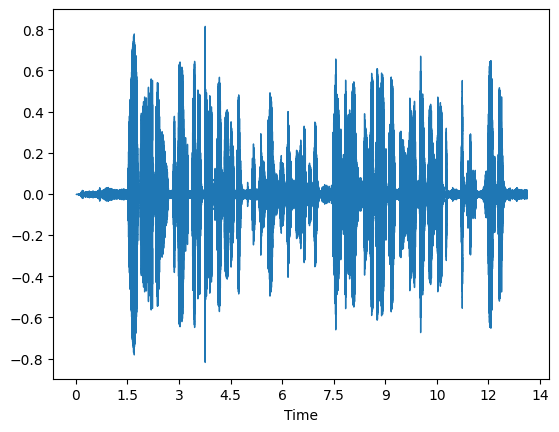

(1025, 411)


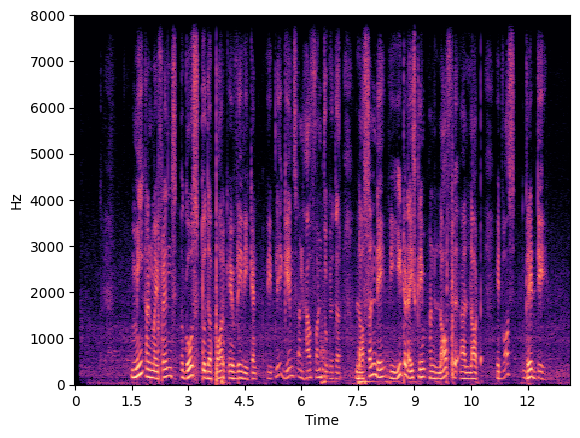

In [37]:
plt.figure()
librosa.display.waveshow(y=audio, sr=sampling_rate, max_points=50000, x_axis='time', offset=0.0);
plt.show()
specto_audio = librosa.stft(audio)
specto_audio = librosa.amplitude_to_db(np.abs(specto_audio), ref=np.max)
print(specto_audio.shape)
librosa.display.specshow(specto_audio, sr=sampling_rate, x_axis='time', y_axis='hz');

**Change Type of Data**

In [38]:
if max(np.abs(audio)) <= 1:
    audio = (audio * (2**15 - 1))
audio = audio.astype(np.int16)

**Convert Audio to Mel Spectrum**

In [39]:
def audio_to_mel(audio, sampling_rate):
    assert sampling_rate == 16000, "Only 16 KHz audio supported"
    preemph = 0.97
    preemphased = np.concatenate([audio[:1], audio[1:] - preemph * audio[:-1].astype(np.float32)])

    # Calculate the window length.
    win_length = round(sampling_rate * 0.02)

    # Based on the previously calculated window length, run short-time Fourier transform.
    spec = np.abs(librosa.core.spectrum.stft(preemphased, n_fft=512, hop_length=round(sampling_rate * 0.01),
                  win_length=win_length, center=True, window=scipy.signal.windows.hann(win_length), pad_mode='reflect'))

    # Create mel filter-bank, produce transformation matrix to project current values onto Mel-frequency bins.
    mel_basis = librosa.filters.mel(sr=sampling_rate, n_fft=512, n_mels=64, fmin=0.0, fmax=8000.0, htk=False)
    return mel_basis, spec


def mel_to_input(mel_basis, spec, padding=16):
    # Convert to a logarithmic scale.
    log_melspectrum = np.log(np.dot(mel_basis, np.power(spec, 2)) + 2 ** -24)

    # Normalize the output.
    normalized = (log_melspectrum - log_melspectrum.mean(1)[:, None]) / (log_melspectrum.std(1)[:, None] + 1e-5)

    # Calculate padding.
    remainder = normalized.shape[1] % padding
    if remainder != 0:
        return np.pad(normalized, ((0, 0), (0, padding - remainder)))[None]
    return normalized[None]

**Run Conversion from Audio to Mel Format**

In [40]:
mel_basis, spec = audio_to_mel(audio=audio.flatten(), sampling_rate=sampling_rate)

**Visualize Mel Spectrogram**

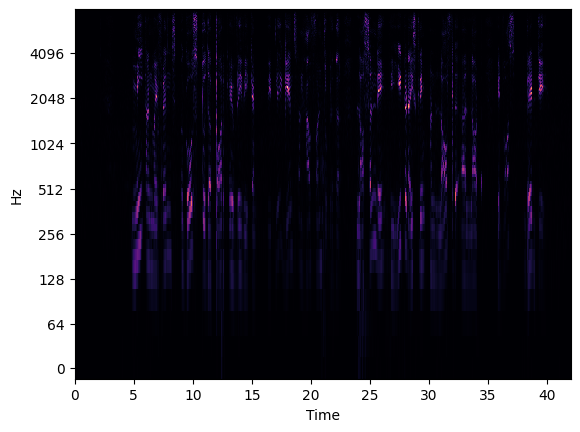

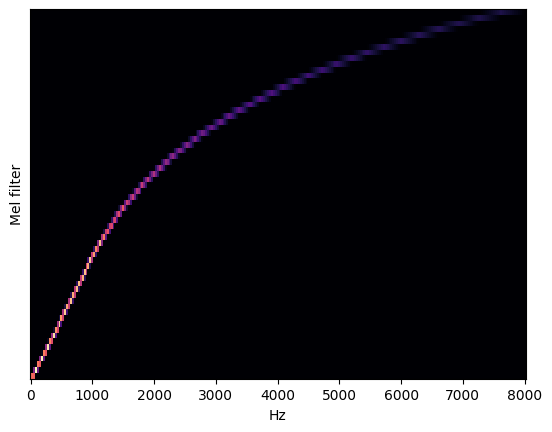

In [41]:
librosa.display.specshow(data=spec, sr=sampling_rate, x_axis='time', y_axis='log');
plt.show();
librosa.display.specshow(data=mel_basis, sr=sampling_rate, x_axis='linear');
plt.ylabel('Mel filter');

**Adjust Mel scale to Input**

In [42]:
audio = mel_to_input(mel_basis=mel_basis, spec=spec)

**Load the Model**

In [43]:
core = ov.Core()
print(core.available_devices)


['CPU', 'GPU']


In [44]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [45]:
model = core.read_model(
    model=f"{model_folder}/public/{model_name}/{precision}/{model_name}.xml"
)
model_input_layer = model.input(0)
shape = model_input_layer.partial_shape
shape[2] = -1
model.reshape({model_input_layer: shape})
compiled_model = core.compile_model(model=model, device_name=device.value)

**Do Inference**

In [46]:
character_probabilities = compiled_model([ov.Tensor(audio)])[0]

**Read Output**

In [47]:
# Remove unnececery dimension
character_probabilities = np.squeeze(character_probabilities)

# Run argmax to pick most possible symbols
character_probabilities = np.argmax(character_probabilities, axis=1)

**Implementation of Decoding**

In [48]:
def ctc_greedy_decode(predictions):
    previous_letter_id = blank_id = len(alphabet) - 1
    transcription = list()
    for letter_index in predictions:
        if previous_letter_id != letter_index != blank_id:
            transcription.append(alphabet[letter_index])
        previous_letter_id = letter_index
    return ''.join(transcription)

**Run Decoding and Print Output**

In [49]:
transcription = ctc_greedy_decode(character_probabilities)
print(transcription)

me and my friends goes to the park every weekend we play games and have fun together last sunday he heated ice cream and loughed a lot it was great day


## Grammatical Error Correction with OpenVINO
**Grammar Checker**

In [50]:
grammar_checker_model_id = "textattack/roberta-base-CoLA"
grammar_checker_dir = Path("roberta-base-cola")
grammar_checker_tokenizer = AutoTokenizer.from_pretrained(grammar_checker_model_id)

if grammar_checker_dir.exists():
    grammar_checker_model = OVModelForSequenceClassification.from_pretrained(grammar_checker_dir, device=device.value)
else:
    grammar_checker_model = OVModelForSequenceClassification.from_pretrained(grammar_checker_model_id, export=True, device=device.value)
    grammar_checker_model.save_pretrained(grammar_checker_dir)

loading configuration file config.json from cache at C:\Users\brind/.cache\huggingface\hub\models--textattack--roberta-base-CoLA\snapshots\3ccf3a400f2fa75ff257eac171047603ffbe84f1\config.json
Model config RobertaConfig {
  "_name_or_path": "textattack/roberta-base-CoLA",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "finetuning_task": "glue:cola",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.34.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading file vocab.json from cache at

In [53]:
input_text =str(transcription)
grammar_checker_pipe = pipeline("text-classification", model=grammar_checker_model, tokenizer=grammar_checker_tokenizer)
result = grammar_checker_pipe(input_text)[0]
print(f"input text: {input_text}")
print(f'predicted label: {"contains_errors" if result["label"] == "LABEL_1" else "no errors"}')
print(f'predicted score: {result["score"] :.2}')

input text: me and my friends goes to the park every weekend we play games and have fun together last sunday he heated ice cream and loughed a lot it was great day
predicted label: no errors
predicted score: 0.75


**Grammar Corrector**

In [52]:
grammar_corrector_model_id = "pszemraj/flan-t5-large-grammar-synthesis"
grammar_corrector_dir = Path("flan-t5-large-grammar-synthesis")
grammar_corrector_tokenizer = AutoTokenizer.from_pretrained(grammar_corrector_model_id)

if grammar_corrector_dir.exists():
    grammar_corrector_model = OVModelForSeq2SeqLM.from_pretrained(grammar_corrector_dir, device=device.value)
else:
    grammar_corrector_model = OVModelForSeq2SeqLM.from_pretrained(grammar_corrector_model_id, export=True, device=device.value)
    grammar_corrector_model.save_pretrained(grammar_corrector_dir)

loading file spiece.model from cache at C:\Users\brind/.cache\huggingface\hub\models--pszemraj--flan-t5-large-grammar-synthesis\snapshots\d45c90f835904f6c3fdf320e74fa6e894e960871\spiece.model
loading file tokenizer.json from cache at C:\Users\brind/.cache\huggingface\hub\models--pszemraj--flan-t5-large-grammar-synthesis\snapshots\d45c90f835904f6c3fdf320e74fa6e894e960871\tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at C:\Users\brind/.cache\huggingface\hub\models--pszemraj--flan-t5-large-grammar-synthesis\snapshots\d45c90f835904f6c3fdf320e74fa6e894e960871\special_tokens_map.json
loading file tokenizer_config.json from cache at C:\Users\brind/.cache\huggingface\hub\models--pszemraj--flan-t5-large-grammar-synthesis\snapshots\d45c90f835904f6c3fdf320e74fa6e894e960871\tokenizer_config.json
loading configuration file flan-t5-large-grammar-synthesis\config.json
Model config T5Config {
  "_name_or_path": "flan-t5-large-grammar-s

In [54]:
grammar_corrector_pipe = pipeline("text2text-generation", model=grammar_corrector_model, tokenizer=grammar_corrector_tokenizer)


In [57]:
result = grammar_corrector_pipe(input_text)[0]


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "max_length": 512,
  "min_length": 8,
  "no_repeat_ngram_size": 4,
  "num_beams": 2,
  "pad_token_id": 0
}



**Final output**

In [58]:
print(f"input text:     {input_text}") 
print(f'generated text: {result["generated_text"]}') 

input text:     me and my friends goes to the park every weekend we play games and have fun together last sunday he heated ice cream and loughed a lot it was great day
generated text: Me and my friends go to the park every weekend and play games and have fun together. Last Sunday we had ice cream and it was a lot of fun.
